[ 0.70710678  0.        ]
path = data/raw/02_1[14]_0*
data/raw/02_11_01_エネマネハウス_iphone_胸ポケット_裏上_正常_まっすぐ帰宅
..............................
data/raw/02_11_02_エネマネハウス_iphone_カバン_裏上_正常_まっすぐ帰宅
..............................
data/raw/02_11_03_エネマネハウス_iphone_胸ポケット_裏上_正常_5秒後まっすぐ帰宅
..............................
data/raw/02_11_04_エネマネハウス_iphone_カバン_裏上_正常_5秒後まっすぐ帰宅
..............................
data/raw/02_14_01_エネマネハウス_iphone_胸ポケット_裏上_異常_エリア境界で静止
..............................
data/raw/02_14_02_エネマネハウス_iphone_カバン_裏上_異常_エリア境界で静止
..............................
n hidden: 2
--normal score
[2.0271249, 0.17197292, 0.015961748, 0.33186942, 0.0034121468, 2.1723421, 0.65468496, 0.061213691, 0.66339427, 0.13800541, 0.055455912, 0.7012856, 0.050562155, 0.083376855, 1.0826982, 2.1302102, 0.17266971, 0.083491392, 0.065945856, 0.034978453, 0.68356466, 0.21420936, 0.85278386, 0.36405632, 0.43124232, 0.52047962, 0.31242216, 0.50461811, 0.73267907, 0.10132289, 0.11897439, 1.6769689, 0.38194811, 0.59327602, 0.23

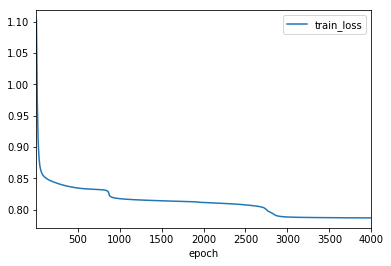

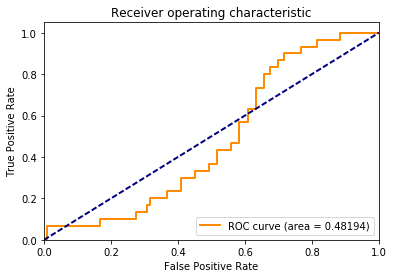

auc 0.48194


In [3]:
import sys
import notebookutil as nbu
sys.meta_path.append(nbu.NotebookFinder())
import datasets
import math
import os
import pandas as pd
import numpy as np
import roc_auc
import estimator_kmeans as kmeans
import estimator_knn as knn
import estimator_nn as nn
import estimator_lof as lof
import estimator_rssibased as rssie
from datetime import datetime
import json
from IPython.display import display, HTML

In [4]:
# data loader
#ds = datasets.load('data/raw/0[12]_[01][123]_0[1234]*_*')
ds = datasets.load('data/raw/0[12]_[01][14]_0[1234]*_*')

path = data/raw/0[12]_[01][14]_0[1234]*_*
data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
..............................
data/raw/01_01_02_4F実験室_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅
...x..........................
data/raw/01_01_03_4F実験室_XperiaZ3_胸ポケット_裏上_正常_5秒後まっすぐ帰宅
.........................x....
data/raw/01_01_04_4F実験室_XperiaZ3_カバン_裏上_正常_5秒後まっすぐ帰宅
.....................x........
data/raw/01_04_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_エリア境界で静止
.............................
data/raw/01_04_02_4F実験室_XperiaZ3_カバン_裏上_異常_エリア境界で静止
.............................
data/raw/01_11_01_エネマネハウス_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
..............................
data/raw/01_11_02_エネマネハウス_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅
..............................
data/raw/01_11_03_エネマネハウス_XperiaZ3_胸ポケット_裏上_正常_5秒後まっすぐ帰宅
..............................
data/raw/01_11_04_エネマネハウス_XperiaZ3_カバン_裏上_正常_5秒後まっすぐ帰宅
..............................
data/raw/01_14_01_エネマネハウス_XperiaZ3_胸ポケット_裏上_異常_エリア境界で静止
..............................
data/raw/01_14_02_エネマネハウス_Xpe

In [18]:
# general estimator test
def eval_estimator(
    model,
    sensor_type = ['rssi.a','rssi.b', ['linear_accel[0]','linear_accel[1]','linear_accel[2]']],
    n_record = 3,
    base = '01_11_01',
    normal = '^01_11',
    anomaly = '^01_1[23]',
    ms_interval = 20,
    ma_window = 3,
    n_train = 3,
    normalize = True):
    
    if n_record >= 0:
        n_record_before = n_record
        n_record_after  = 0
    else:
        n_record_before = 0
        n_record_after  = -n_record
        
    # recalc input
    drop_interval = int(ms_interval / 20)
    
    # get data
    dfl_t = datasets.get_data(ds, title=base, before=n_record_before, after=n_record_after,
                              column=sensor_type, drop_interval=drop_interval)[:(n_train + 1)]
    dfl_n = datasets.get_data(ds, title=normal, before=n_record_before, after=n_record_after,
                              column=sensor_type, drop_interval=drop_interval)
    dfl_o = datasets.get_data(ds, title=anomaly, before=n_record_before, after=n_record_after,
                              column=sensor_type, drop_interval=drop_interval)
    
    # limit data by n_record
    dfl_t = [df for df in dfl_t if len(df) >= abs(n_record)]
    dfl_n = [df for df in dfl_n if len(df) >= abs(n_record)]
    dfl_o = [df for df in dfl_o if len(df) >= abs(n_record)]
    
    # moving average
    dfl_t = datasets.moving_average(dfl_t, window=ma_window, min_periods=ma_window)
    dfl_n = datasets.moving_average(dfl_n, window=ma_window, min_periods=ma_window)
    dfl_o = datasets.moving_average(dfl_o, window=ma_window, min_periods=ma_window)
    
    # normalize
    if normalize == True:
        dfl_t_n = datasets.normalize_by_base_data(dfl_t, dfl_t, sensor_type)
        dfl_n_n = datasets.normalize_by_base_data(dfl_t, dfl_n, sensor_type)
        dfl_o_n = datasets.normalize_by_base_data(dfl_t, dfl_o, sensor_type)

    # get numpy array
    data_2d_t = [df.as_matrix() for df in dfl_t_n]
    data_2d_n = [df.as_matrix() for df in dfl_n_n]
    data_2d_o = [df.as_matrix() for df in dfl_o_n]

    # to list of numpy.array
    data_t = [d.ravel() for d in data_2d_t]
    data_n = [d.ravel() for d in data_2d_n]
    data_o = [d.ravel() for d in data_2d_o]
    
    # get auc score
    model.fit(data_t)
        
    score_n = model.decision_function(data_n)
    score_o = model.decision_function(data_o)
    auc = roc_auc.get_auc_from_normal_outlier(score_n, score_o, graph=False)
    
    return auc

#eval_estimator()

In [19]:
def read_csv(fname):
    df = pd.read_csv(fname, index_col=0)
    return df
#read_csv()

In [ ]:
# grid search implementation (under test)
def _get_estimator_models():
    model_params = []
    
    # k-means based estimator
    #range_n_clusters = np.arange(1, 10, 2)
    range_n_clusters = np.array([1])
    range_max_iter = np.array([3])
    mesh_data = np.meshgrid(range_n_clusters, range_max_iter)
    for n_clusters, max_iter in zip(mesh_data[0].ravel(), mesh_data[1].ravel()):
        model_params.append({'n_clusters': n_clusters, 'max_iter': max_iter, 'type': 'k-means'})
    
    # kNN based estimator
    #range_n_neighbors = np.arange(1, 10, 2)
    range_n_neighbors = np.array([5])
    range_algorithm = np.array(['ball_tree'])
    mesh_data = np.meshgrid(range_n_neighbors, range(len(range_algorithm)))
    for n_neighbors, algorithm_idx in zip(mesh_data[0].ravel(), mesh_data[1].ravel()):
        model_params.append({'n_neighbors': n_neighbors, 'algorithm': range_algorithm[algorithm_idx], 'type': 'kNN'})
    
    # LOF based estimator
    #range_n_neighbors = np.arange(1, 10, 2)
    range_n_neighbors = np.array([5])
    range_algorithm = np.array(['ball_tree'])
    mesh_data = np.meshgrid(range_n_neighbors, range(len(range_algorithm)))
    for n_neighbors, algorithm_idx in zip(mesh_data[0].ravel(), mesh_data[1].ravel()):
        model_params.append({'n_neighbors': n_neighbors, 'algorithm': range_algorithm[algorithm_idx], 'type': 'LOF'})
    
    # NN based estimator
    range_num_of_training_epochs = np.array([100, 400])
    #range_num_of_hidden_nodes = np.array([4, 8, 16, 32])
    range_num_of_hidden_nodes = np.array([32])
    #range_num_of_training_epochs = np.array([100])
    #range_num_of_hidden_nodes = np.array([8])
    
    range_size_of_mini_batch = np.array([10])
    range_size_of_test_batch = np.array([10])
    range_learning_rate = np.array([0.02])
    mesh_data = np.meshgrid(range_num_of_training_epochs, range_num_of_hidden_nodes, range_size_of_mini_batch,
                           range_size_of_test_batch, range_learning_rate)
    for num_of_training_epochs, num_of_hidden_nodes, size_of_mini_batch, size_of_test_batch, learning_rate in zip(mesh_data[0].ravel(), mesh_data[1].ravel(), mesh_data[2].ravel(), mesh_data[3].ravel(), mesh_data[4].ravel()):
        model_params.append({'num_of_training_epochs': num_of_training_epochs,
                             'num_of_hidden_nodes': num_of_hidden_nodes,
                             'size_of_mini_batch': size_of_mini_batch,
                             'size_of_test_batch': size_of_test_batch,
                             'learning_rate': learning_rate,
                             'type': 'NN'
                            })
    
    # rssi based estimator
    #models.append(rssie.EstimatorRssiBased())
    model_params.append({'type': 'rssi_based'})
    
    return model_params

def _get_grid_test_case(model_params, is_Android):
    # parameters other than algorithm specific
    sensor_master_ios = [
        ['rssi.a', 'rssi.b'],
        #['rssi.a', 'rssi.b', ['acceleration.x', 'acceleration.y', 'acceleration.z']],
        ['rssi.a', 'rssi.b', ['gyro.rotationRate.x', 'gyro.rotationRate.y', 'gyro.rotationRate.z']],
        #['rssi.a', 'rssi.b', ['magneticField.x', 'magneticField.y', 'magneticField.z']],
        #['rssi.a', 'rssi.b', ['attitude.roll', 'attitude.pitch', 'attitude.yaw']],
        ['rssi.a', 'rssi.b', ['rotationRate.x', 'rotationRate.y', 'rotationRate.z']],
        #['rssi.a', 'rssi.b', ['gravity.x', 'gravity.y', 'gravity.z']],
        ['rssi.a', 'rssi.b', ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']],
        ['rssi.a', 'rssi.b', ['rotationRate.x', 'rotationRate.y', 'rotationRate.z'], ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']],
    ]
    sensor_master_android = [
        ['rssi.a', 'rssi.b'],
        ['rssi.a', 'rssi.b', ['linear_accel[0]', 'linear_accel[1]', 'linear_accel[2]']],
        #['rssi.a', 'rssi.b', ['accelerometer[0]', 'accelerometer[1]', 'accelerometer[2]']],
        ['rssi.a', 'rssi.b', ['gravity[0]', 'gravity[1]', 'gravity[2]']],
        ['rssi.a', 'rssi.b', ['gyro[0]', 'gyro[1]', 'gyro[2]']],
        #['rssi.a', 'rssi.b', ['rotation[0]', 'rotation[1]', 'rotation[2]']],
        #['rssi.a', 'rssi.b', ['game_rotation[0]', 'game_rotation[1]', 'game_rotation[2]']],
        #['rssi.a', 'rssi.b', ['magnetic[0]', 'magnetic[1]', 'magnetic[2]']],
        ['rssi.a', 'rssi.b', ['linear_accel[0]', 'linear_accel[1]', 'linear_accel[2]'], ['gyro[0]', 'gyro[1]', 'gyro[2]']],
        #['rssi.a', 'rssi.b', 'pressure'],
    ]
    if is_Android == True:
        sensor_master_s = [json.dumps(s) for s in sensor_master_android]
    else:
        sensor_master_s = [json.dumps(s) for s in sensor_master_ios]

    #range_n_record = np.array([-100, -60, -40, -20, -5, -3, -2, -1, 0, 1, 2, 5, 20])
    range_n_record = np.array([-20, -5, -3, -2, -1, 0, 10, 20, 50])
    #range_n_train = np.array([1, 5, 10, 20])
    range_n_train = np.array([1, 5])
    range_ms_interval = np.array([100])
    #range_ma_window = np.arange(1, 4, 2)
    range_ma_window = np.array([1])
    
    mesh_data = np.meshgrid(range(len(model_params)), range_n_record, range_n_train,
                            range_ms_interval, range_ma_window, range(len(sensor_master_s)))

    # create grid test case
    test_case = []
    for model_param_idx, n_record, n_train, ms_interval, ma_window, sensor_idx in zip(mesh_data[0].ravel(), mesh_data[1].ravel(), mesh_data[2].ravel(),
               mesh_data[3].ravel(), mesh_data[4].ravel(), mesh_data[5].ravel()):
        # save test case and result
        _t = {'n_record': n_record, 'n_train': n_train,
              'ms_interval': ms_interval, 'ma_window': ma_window, 'sensor_type': sensor_master_s[sensor_idx]}
        _t.update(model_params[model_param_idx])
        test_case.append(_t)
    
    # create df for test case
    df = pd.DataFrame(test_case)
    
    return df

def _remove_unavailable_test_case(df):
    # shold be done after the merge the existing csv
    
    # remove unavailable test case
    df = df[~(df['n_train'] < df['n_neighbors'])]
    df = df[~(df['n_train'] < df['n_clusters'])]
    df = df[~((df['type'] == 'rssi_based') & (df['sensor_type'].apply(lambda x: len(json.loads(x)) > 2)))]
    df = df[~((df['n_record'] >= 0) & (df['n_record'] + 1 < df['ma_window']))]
    df = df[~((df['n_record'] < 0) & (-df['n_record'] + 1 < df['ma_window']))]
    df = df[~((df['n_record'] < 0) & (-df['n_record'] * df['ms_interval'] > 1000))]
    return df

def _run_test(df, base, normal, anomaly):
    # set the data title
    #base = '01_01_01'
    #normal = '^01_01'
    #anomaly = '^02_1[23]'
    #anomaly = '^01_04'
    
    csv_fname = 'test_record_%s__%s__%s.csv' % (base, normal, anomaly) 

    # if auc is already computed in some test case, merge the result. 
    if os.path.exists(csv_fname):
        df_past = read_csv(csv_fname)
        keys = list(df.columns.values)
        df = pd.merge(df, df_past, on=keys, how='outer')
    else:
        df['auc'] = np.nan
    
    # show test size
    imcomplete_test_case = len([x for x in df['auc'].values if np.isnan(x)])
    print('total test case: %d' % (len(df.index)))
    print('imcomplete test case: %d' %(imcomplete_test_case))
        
    # run test
    for i, (k, t) in enumerate(df[df['auc'].isnull()].iterrows()):
        if i % 10 == 0:
            print("%d / %d at %s"%(i+1, imcomplete_test_case, datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
            df.to_csv(csv_fname )

        # generate model from parameter
        if t['type'] == 'k-means':
            model = kmeans.EstimatorKmeans(n_clusters=int(t['n_clusters']), max_iter=int(t['max_iter']))
        elif t['type'] == 'kNN':
            model = knn.EstimatorKNN(n_neighbors=int(t['n_neighbors']), algorithm=t['algorithm'])
        elif t['type'] == 'LOF':
            model = lof.EstimatorLOF(n_neighbors=int(t['n_neighbors']), algorithm=t['algorithm'])
        elif t['type'] == 'NN':
            model = nn.EstimatorNN(num_of_hidden_nodes=int(t['num_of_hidden_nodes']),
                                   num_of_training_epochs=int(t['num_of_training_epochs']),
                                   size_of_mini_batch=int(t['size_of_mini_batch']),
                                   size_of_test_batch=int(t['size_of_test_batch']),
                                   learning_rate=t['learning_rate'])
        elif t['type'] == 'rssi_based':
            model = rssie.EstimatorRssiBased()
        else:
            print('! "%s" is not defined'%(t['type']))
            return None
        
        #print(model.get_params())
        #print(t)
        
        #  run a test
        auc = eval_estimator(model, base=base, normal=normal, anomaly=anomaly,
                             n_train=t['n_train'], sensor_type=json.loads(t['sensor_type']), n_record=t['n_record'],
                             ms_interval=t['ms_interval'], ma_window=t['ma_window'])
        df.loc[[k], 'auc'] = auc
        
        # deallocate memory space for the model
        del model
    
    df.to_csv(csv_fname )
    return df

def test():
    test_set = [
        {'base': '01_01_01', 'normal': '^01_01', 'anomaly': '^01_04', 'is_Android': True},
        {'base': '02_01_01', 'normal': '^02_01', 'anomaly': '^02_04', 'is_Android': False},
    ]
    
    for ts in test_set:
        print(ts)
        model_params = _get_estimator_models()
        df = _get_grid_test_case(model_params, is_Android=ts['is_Android'])
        df = _remove_unavailable_test_case(df)
        df = _run_test(df,
                       base = ts['base'],
                       normal = ts['normal'],
                       anomaly = ts['anomaly'])
    
    """ 
    model_params = _get_estimator_models()
    df = _get_grid_test_case(model_params, is_Android=True)
    df = _remove_unavailable_test_case(df)
    df = _run_test(df,
                   base = '01_01_01',
                   normal = '^01_01',
                   anomaly = '^01_04')
    """ 
    return df

test()

{'base': '01_01_01', 'is_Android': True, 'anomaly': '^01_04', 'normal': '^01_01'}
total test case: 3162
imcomplete test case: 0
{'base': '02_01_01', 'is_Android': False, 'anomaly': '^02_04', 'normal': '^02_01'}
total test case: 1122
imcomplete test case: 226
1 / 226 at 2017/05/15 11:15:07
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 32
11 / 226 at 2017/05/15 11:15:20
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 32
21 / 226 at 2017/05/15 11:15:34
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 32
31 / 226 at 2017/05/15 11:15:47
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 32
41 / 226 at 2017/05/15 11:16:01
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 32
n hidden: 

In [ ]:
import gc
gc.collect()